In [1]:
import numpy as np
import tensorflow
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import keras
from keras import backend as K
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms
import tensorflow_datasets as tfds
import glob

from matplotlib import pyplot as plt
%matplotlib inline
print(os.listdir("data"))

['sampleSubmission.csv', 'test', 'train']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
files = glob.glob('data/train/*.jpg')
for f in files:
    img = Image.open(f)
    img_resize = img.resize((128,128))
    title, ext = os.path.splitext(f)
    img_resize.save(title+ext)
print(len(files))

211


In [3]:
filenames = os.listdir("data/train")
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'mountain':
        categories.append(1)
    elif category =='road':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head(240)

,filename,category
0,mountain_bike_0.jpg,1
1,mountain_bike_1.jpg,1
2,mountain_bike_10.jpg,1
3,mountain_bike_100.jpg,1
4,mountain_bike_101.jpg,1
...,...,...
206,road_bike_95.jpg,1
207,road_bike_96.jpg,1
208,road_bike_97.jpg,1
209,road_bike_98.jpg,1


<AxesSubplot:>

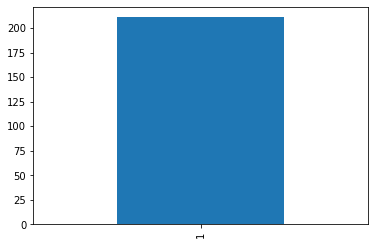

In [5]:
df['category'].value_counts().plot.bar()

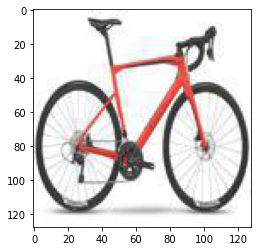

In [6]:
sample = random.choice(filenames)
image = keras.utils.load_img("data/train/"+sample)
plt.imshow(image)

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()

model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 8)       224       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 8)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 16)      

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
earlystop = EarlyStopping(patience=10)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
callbacks = [earlystop, learning_rate_reduction]

In [13]:
df["category"] = df["category"].replace({0: 'Not_Bike', 1: 'Bike'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

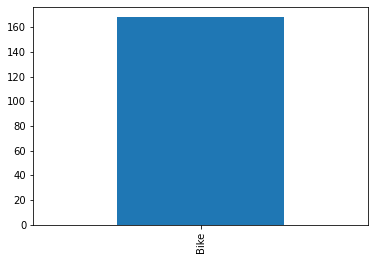

In [15]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

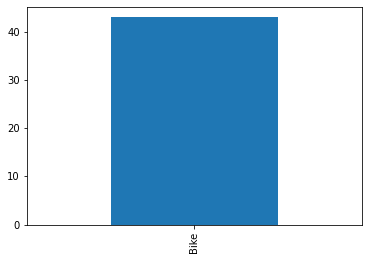

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 168 validated image filenames belonging to 1 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 43 validated image filenames belonging to 1 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


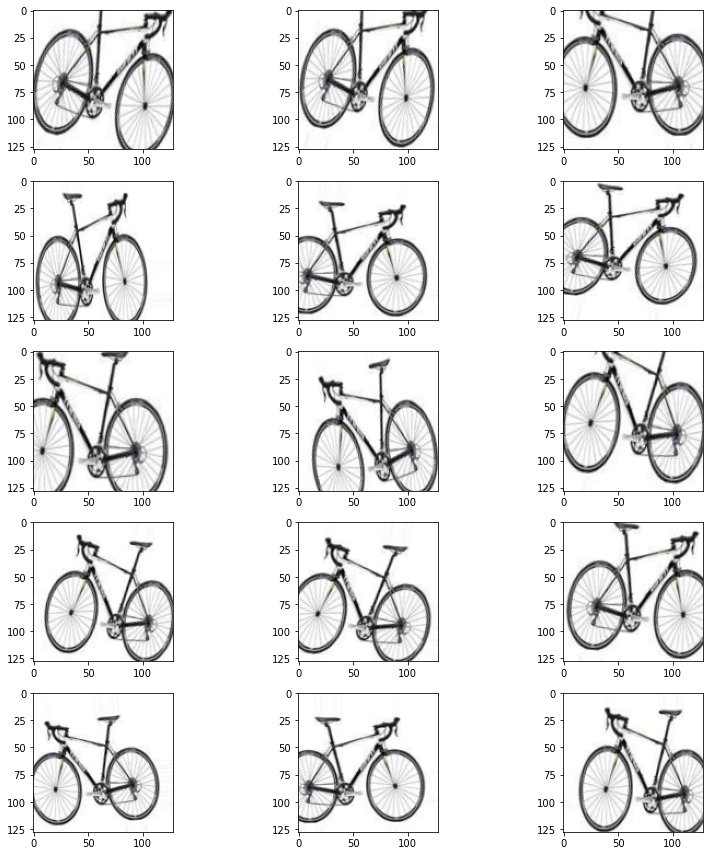

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [22]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\sky15\AppData\Local\Temp/ipykernel_4380/612699584.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
11/11 [==============================] - 4s 225ms/step - loss: 2.3984 - accuracy: 0.4379 - val_loss: 1.3937 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 2s 150ms/step - loss: 1.9991 - accuracy: 0.4379 - val_loss: 1.5090 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 2s 148ms/step - loss: 2.0606 - accuracy: 0.4641 - val_loss: 1.6540 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 2s 162ms/step - loss: 2.0179 - accuracy: 0.4444 - val_loss: 2.2220 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 2s 162ms/step - loss: 1.8888 - accuracy: 0.4641 - val_loss: 2.7989 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 2s 150ms/step - loss: 1.8196 - accuracy: 0.4641 - val_loss: 3.6061 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/50
11/11 [==============================] 

In [23]:
model.save_weights("model.h5")

KeyError: 'acc'

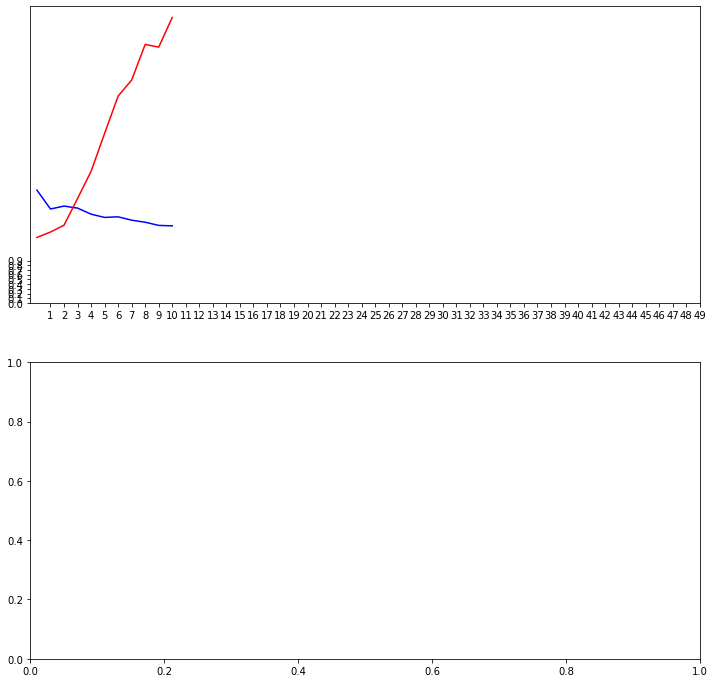

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [25]:
test_filenames = os.listdir("data/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 48 validated image filenames.


In [27]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\sky15\AppData\Local\Temp/ipykernel_4380/3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [28]:
test_df['category'] = np.argmax(predict, axis=-1)

In [29]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [30]:
test_df['category'] = test_df['category'].replace({ 'Bike': 1, 'Not_Bike': 0 })


<AxesSubplot:>

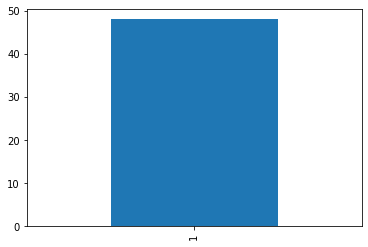

In [31]:
test_df['category'].value_counts().plot.bar()

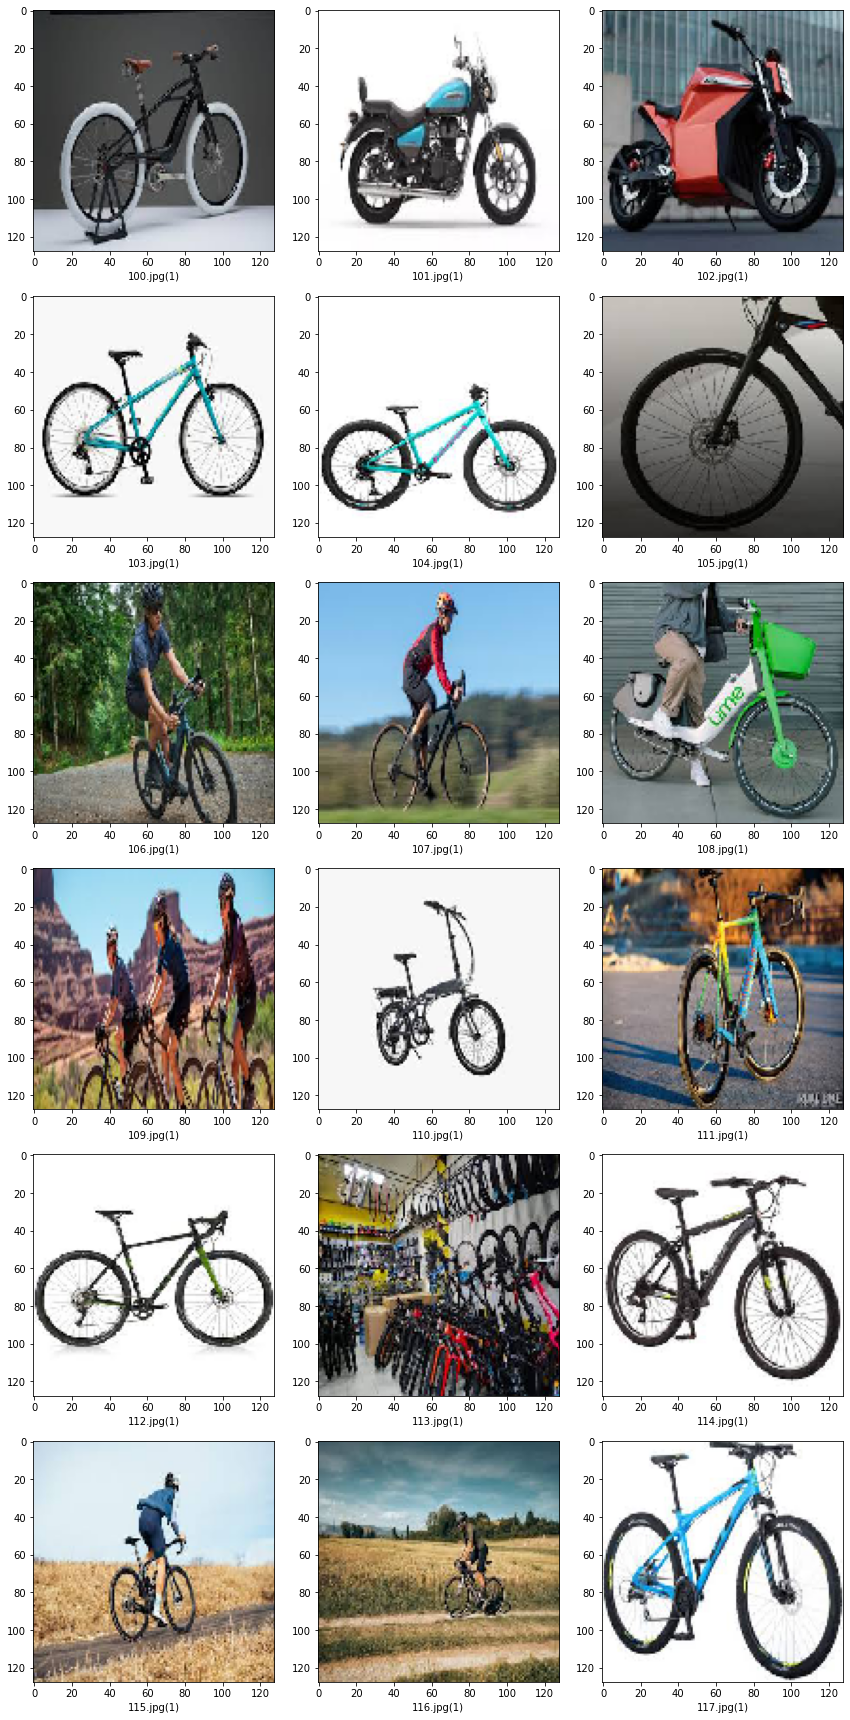

In [32]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = keras.utils.load_img("data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [33]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)